# Emotion-Recognition Kaggle Model V7

## Transfer Learning

This time I will try to use VGG16 as base model, remove the last layers and add my own for the emotion detection and see how it performs.

In [1]:
# Imports
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout, Input
from sklearn.metrics import confusion_matrix
import random
import glob
import itertools
import os
import shutil
import seedir as sd
import matplotlib.pyplot as plt
import plotly.graph_objects as pgo
import warnings
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, Image
from livelossplot import PlotLossesKerasTF

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
# Classses Distribution
print("Dataset Classes Distribution")

# Path to dataset
dataset_path = '../datasets/kaggle_dataset_train/'

# Let's display and count the files in the Kaggle training dataset
sd.seedir(dataset_path, style='emoji', itemlimit=10, depthlimit=1, beyond='content')

# Find number of images for each class
classes = []
values = []
for emotion in os.listdir(dataset_path):
    classes.append(emotion)
    values.append(len(os.listdir(dataset_path+emotion)))

# Chart visualization of the classes
fig = pgo.Figure(data=[pgo.Pie(labels=classes, values=values, hole=.4)])
fig.show()

Dataset Classes Distribution
📁 /
├─📁 angry/
│ └─0 folder(s), 3595 file(s)
├─📁 disgust/
│ └─0 folder(s), 393 file(s)
├─📁 fear/
│ └─0 folder(s), 3688 file(s)
├─📁 happy/
│ └─0 folder(s), 6493 file(s)
├─📁 neutral/
│ └─0 folder(s), 4469 file(s)
├─📁 sad/
│ └─0 folder(s), 4347 file(s)
└─📁 surprise/
  └─0 folder(s), 2854 file(s)


In [3]:
# I create a different folder for the validation set
os.chdir('../datasets/')
if os.path.isdir('kaggle_dataset_validate/') is False:
    os.makedirs('kaggle_dataset_validate/angry')
    os.makedirs('kaggle_dataset_validate/disgust')
    os.makedirs('kaggle_dataset_validate/fear')
    os.makedirs('kaggle_dataset_validate/happy')
    os.makedirs('kaggle_dataset_validate/neutral')
    os.makedirs('kaggle_dataset_validate/sad')
    os.makedirs('kaggle_dataset_validate/surprise')

    # Now I move 10% of random images from each train class to the proper validation set
    for i in random.sample(glob.glob('kaggle_dataset_train/angry/*'), 399):
        shutil.move(i, 'kaggle_dataset_validate/angry')        
    for i in random.sample(glob.glob('kaggle_dataset_train/disgust/*'), 43):
        shutil.move(i, 'kaggle_dataset_validate/disgust')
    for i in random.sample(glob.glob('kaggle_dataset_train/fear/*'), 409):
        shutil.move(i, 'kaggle_dataset_validate/fear')
    for i in random.sample(glob.glob('kaggle_dataset_train/happy/*'), 721):
        shutil.move(i, 'kaggle_dataset_validate/happy')
    for i in random.sample(glob.glob('kaggle_dataset_train/neutral/*'), 496):
        shutil.move(i, 'kaggle_dataset_validate/neutral')
    for i in random.sample(glob.glob('kaggle_dataset_train/sad/*'), 483):
        shutil.move(i, 'kaggle_dataset_validate/sad')
    for i in random.sample(glob.glob('kaggle_dataset_train/surprise/*'), 317):
        shutil.move(i, 'kaggle_dataset_validate/surprise')


os.chdir('../notebooks')

In [4]:
# Process the data
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Define sets
# Since the tesing set has more data than the created validate, we will use test as validate and validate as test
training_path = '../datasets/kaggle_dataset_train/'
valididation_path = '../datasets/kaggle_dataset_test/'
testing_path = '../datasets/kaggle_dataset_validate/'

Num GPUs Available:  1


Now we have to preprocess the images for VGG16. Not only that, our images have only 1 channel (grayscale) but the VGG16 model requires 3 channel (RBG). The VGG16 paper states:

“The only pre-processing we do is subtracting the mean RGB value,
computed on the training set, from each pixel.”

VGG16 was trained on the ImageNet images, so the mean RGB values are calculated based on the ImageNet dataset.

To compute the mean on single color channel, for example red, we compute the average red value of all the pixels across every ImageNet image. The same procedure applies for the other two color channels, green and blue. Then in order to preprocess every image, we subtract the mean red value from the original red value in each pixel. Again the same applies for blue and green.

In [5]:
# The images I have in the Kaggle dataset are in grayscale, for VGG16 I have to convert them to RGB with three channels, what we do is just exand the channel we already have to 3 channels

def vgg16_processed(img):
    # I first "convert" the image to RGB, by repeating the grayscale data x3 along the channel axis
    x=np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
    mychannel=np.repeat(x[:, :, np.newaxis], 3, axis=2)
    # Then I use the tf VGG16 preocessing which basically subtracts the mean BGR value from each pixel
    processedimage = tf.keras.applications.vgg16.preprocess_input(mychannel)
    return processedimage

# I create the same function again but it won't return nothing, it will inded diplay the processed image
def vgg16_processed_tf(img):
   x=np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
   mychannel=np.repeat(x[:, :, np.newaxis], 3, axis=2)
   print("This is the grayscale image after it was converted to color",mychannel)
   processedimage = tf.keras.applications.vgg16.preprocess_input(mychannel)
   print("This is the color image after vgg16 preprocess",processedimage)
   img = processedimage.astype(np.uint8)  # convert back to uint8
   cv2.imshow('img', img)
   cv2.waitKey()

# Here's an example with a grayscale image
# gray = cv2.imread("../datasets/kaggle_dataset_train/angry/Training_3908.jpg")
# vgg16_processed_tf(gray)

This is the grayscale image after it was converted to color [[[162.9837 162.9837 162.9837]
  [127.9872 127.9872 127.9872]
  [113.9886 113.9886 113.9886]
  ...
  [138.9861 138.9861 138.9861]
  [140.9859 140.9859 140.9859]
  [133.9866 133.9866 133.9866]]

 [[146.9853 146.9853 146.9853]
  [113.9886 113.9886 113.9886]
  [101.9898 101.9898 101.9898]
  ...
  [141.9858 141.9858 141.9858]
  [137.9862 137.9862 137.9862]
  [137.9862 137.9862 137.9862]]

 [[111.9888 111.9888 111.9888]
  [105.9894 105.9894 105.9894]
  [ 91.9908  91.9908  91.9908]
  ...
  [139.986  139.986  139.986 ]
  [140.9859 140.9859 140.9859]
  [133.9866 133.9866 133.9866]]

 ...

 [[138.9861 138.9861 138.9861]
  [140.9859 140.9859 140.9859]
  [135.9864 135.9864 135.9864]
  ...
  [153.9846 153.9846 153.9846]
  [170.9829 170.9829 170.9829]
  [190.9809 190.9809 190.9809]]

 [[139.986  139.986  139.986 ]
  [132.9867 132.9867 132.9867]
  [119.988  119.988  119.988 ]
  ...
  [137.9862 137.9862 137.9862]
  [145.9854 145.9854 145.985

As we can see from the result above, the VGG16 preprocessing was correctly done, for example:
`[162.9837 162.9837 162.9837] - [ 59.0447  46.2047  39.3037]` = `[103.939 116.779 123.68]`
Which is the mean blue, green, and red values from ImageNet. VGG16 uses the Caffe library, which uses a BGR color scheme for reading images, that's why the results are in BGR and not the inital RGB.

```python
meanImageNetBGR = {
    blue: 103.939,
    green: 116.779,
    red: 123.68
};
```


In [6]:
# Now we use Keras's ImageDataGenerator class to create batches of data from the training, validation and testing sets
"""
for the preocessing_function I pass the function I created myself above, since we cannot use the normal tf function provided for vgg16 since we had first to expand the grayscale channel
I also remove color_mode since it was set to grayscale, and change target size to 224,224 since it was the original input shape of the VGG16 model
"""
train_batches = ImageDataGenerator(preprocessing_function=vgg16_processed).flow_from_directory(directory=training_path, target_size=(224,224), classes=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'], batch_size=32)
valid_batches = ImageDataGenerator(preprocessing_function=vgg16_processed).flow_from_directory(directory=valididation_path, target_size=(224,224), classes=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'], batch_size=32)
test_batches = ImageDataGenerator(preprocessing_function=vgg16_processed).flow_from_directory(directory=testing_path, target_size=(224,224), classes=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'], batch_size=32, shuffle=False)

Found 25839 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Found 2867 images belonging to 7 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

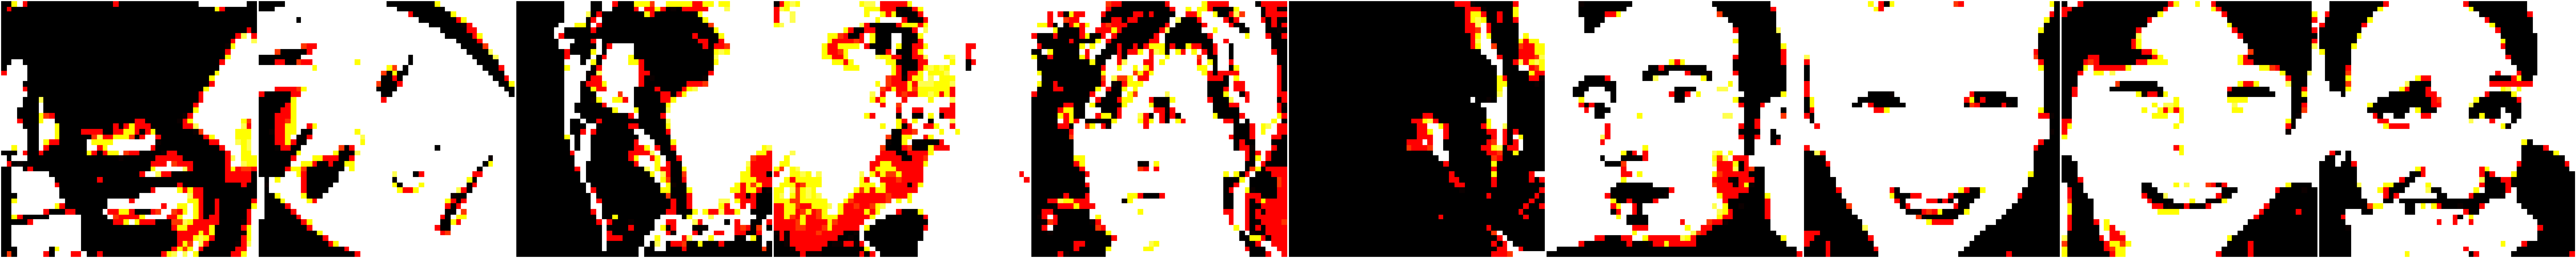

[[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]]


In [7]:
imgs, labels = next(train_batches)

# Plotting function obtained from TensorFlow's documentation to plot the processed images within our Jupyter notebook.
# The classes are represented with the one-hot encoding , for example 'angry' is [1. 0. 0. 0. 0. 0. 0.]

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(224,224))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(imgs)
print(labels)

In [8]:
# I download the VGG16 model
vgg16_model = tf.keras.applications.vgg16.VGG16()
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

As we can see VGG16 so very complex with a total of 138,357,544 parameters. It is is much more complex and sophisticated and has many more layers than the model created in v6.

Notice that the last Dense layer of VGG16 has 1000 outputs. These outputs correspond to the 1000 categories in the ImageNet library. We just have 7, but we have to cut more than just the last dense layer, and there is no optimal number or last layers to remove, so we have to experiment. On this v7 we just remove the last layer and see what happens, then on v8 we remove more layers.

Before we do that, note that the type of Keras models we've been creating were Sequential, by checking out the type of model vgg16_model is, we see that it is of type Model, which is from the Keras' Functional API.

In [9]:
type(vgg16_model)

tensorflow.python.keras.engine.functional.Functional

For now, we're going to go through a process to convert the Functional model to a Sequential model, but on v8 I will try to use Functional.
I first create a new model of type Sequential. We then iterate over each of the layers in vgg16_model, except for the last layer, and add each layer to the new Sequential model.

In [10]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

Now, we have replicated the entire vgg16_model (excluding the output layer) to a new Sequential model, which we've just given the name model. Next, we'll iterate over each of the layers in our new Sequential model and set them to be non-trainable. This freezes the weights and other trainable parameters in each layer so that they will not be trained or updated when we later pass in our emotion images.

In [11]:
for layer in model.layers:
    layer.trainable = False

The reason we don't want to retrain these layers is because faces where already included in the VGG16 set, so we don't want any re-training to occur on the earlier layers, but still this is not that much ideal. For now in v7 we won't train them but in another version we will.
So now we add our new output layer, consisting of only 7 nodes that correspond to our emotions in the dataset This output layer will be the only trainable layer in the model for now in v7.

In [12]:
model.add(Dense(units=7, activation='softmax'))

# We can now check out a summary of our model and see that everything is exactly the same as the original vgg16_model, except for now, the output layer has only 7 nodes, rather than 1000, and the number of trainable parameters has drastically decreased since we froze all the parameters in the earlier layers.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [13]:
# Now that the model is built, we compile the model using the Adam optimizer with a learning rate of 0.0001, a loss of categorical_cross_entropy, and we'll look at accuracy as our performance metric.

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

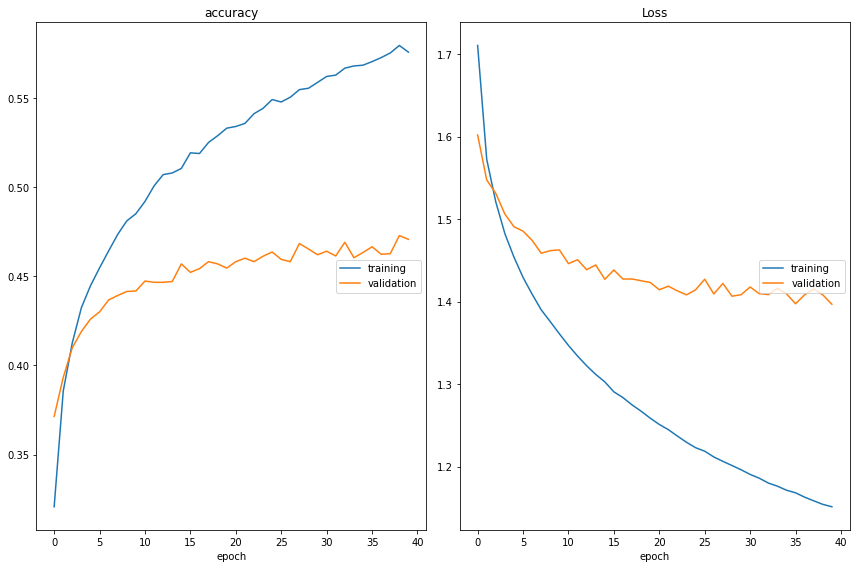

accuracy
	training         	 (min:    0.321, max:    0.579, cur:    0.576)
	validation       	 (min:    0.371, max:    0.473, cur:    0.471)
Loss
	training         	 (min:    1.151, max:    1.710, cur:    1.151)
	validation       	 (min:    1.397, max:    1.602, cur:    1.397)


In [14]:
# I plot the results in real life
# reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, mode='auto', min_lr=0.00001, cooldown=0)

# model_checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', save_weights_only=True, save_best_only=True, mode='max', verbose=1)

callbacks = [PlotLossesKerasTF()]

# Now I will train the model using, I keep the epochs to 40 
model.fit(
    x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=40,
    callbacks=callbacks
)

This time I only got 57% on the training set, so very probably the model is underfitting, I think it's due to the fact that we only removed the last layer and by that point the VGG16 model already formed clear patterns about the 1000 classes it was trained initially on.

Confusion matrix, without normalization
[[110   6  42  85  59  76  21]
 [  5  10   3   8   5  10   2]
 [ 37   2 131  60  43  76  60]
 [ 30   0  32 523  41  73  22]
 [ 45   1  32 103 203  86  26]
 [ 55   2  48  99  68 189  22]
 [ 19   1  38  34  21  12 191]]


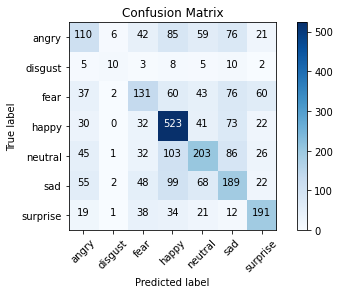

In [15]:
#Plotting Predictions With A Confusion Matrix
# To get a better visualization of these results, we'll plot them in a confusion matrix

test_imgs, test_labels = next(test_batches)
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm_plot_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

This version performed worse than v6 and v5.

In [16]:
# I will save anyways the model for the archive (I specify the name this time)
model.save("kaggle_model_v7.h5")